# Syt-1 C2A RMSD and RMSF

Analysis after 1.5 µs MD simualtion of three replicates (0 to 60 degree orientation)

In [1]:
from MDAnalysis import *
from MDAnalysis import transformations
from MDAnalysis.analysis.rms import RMSD
import nglview as nv
import numpy as np
import os
import pickle

import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objs as go

# ignore deprecation warning frequently raised by numpy for MDAnalysis code
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

universes = [(('../sv_membrane/c2a_only/0_deg/parse_traj_1500ns_nowater.gro', '../sv_membrane/c2a_only/0_deg/parse_traj_1500ns_nowater.xtc'), 'SV', '0deg'),
             (('../sv_membrane/c2a_only/30_deg/parse_traj_1500ns_nowater.gro', '../sv_membrane/c2a_only/30_deg/parse_traj_1500ns_nowater.xtc'), 'SV', '30deg'),
             (('../sv_membrane/c2a_only/60_deg/parse_traj_1500ns_nowater.gro', '../sv_membrane/c2a_only/60_deg/parse_traj_1500ns_nowater.xtc'), 'SV', '60deg'),
#
             (('../sv_membrane/c2a_ca/0_deg/parse_traj_1500ns_nowater.gro', '../sv_membrane/c2a_ca/0_deg/parse_traj_1500ns_nowater.xtc'), 'SV Ca', '0deg'),
             (('../sv_membrane/c2a_ca/30_deg/parse_traj_1500ns_nowater.gro', '../sv_membrane/c2a_ca/30_deg/parse_traj_1500ns_nowater.xtc'), 'SV Ca', '30deg'),
             (('../sv_membrane/c2a_ca/60_deg/parse_traj_1500ns_nowater.gro', '../sv_membrane/c2a_ca/60_deg/parse_traj_1500ns_nowater.xtc'), 'SV Ca', '60deg'),
#            
             (('../pm_membrane/c2a_only/0_deg/parse_traj_1500ns_nowater.gro', '../pm_membrane/c2a_only/0_deg/parse_traj_1500ns_nowater.xtc'), 'PM', '0deg'),
             (('../pm_membrane/c2a_only/30_deg/parse_traj_1500ns_nowater.gro', '../pm_membrane/c2a_only/30_deg/parse_traj_1500ns_nowater.xtc'), 'PM', '30deg'),
             (('../pm_membrane/c2a_only/60_deg/parse_traj_1500ns_nowater.gro', '../pm_membrane/c2a_only/60_deg/parse_traj_1500ns_nowater.xtc'), 'PM', '60deg'),
#
             (('../pm_membrane/c2a_ca/0_deg/parse_traj_1500ns_nowater.gro', '../pm_membrane/c2a_ca/0_deg/parse_traj_1500ns_nowater.xtc'), 'PM Ca', '0deg'),
             (('../pm_membrane/c2a_ca/30_deg/parse_traj_1500ns_nowater.gro', '../pm_membrane/c2a_ca/30_deg/parse_traj_1500ns_nowater.xtc'), 'PM Ca', '30deg'),
             (('../pm_membrane/c2a_ca/60_deg/parse_traj_1500ns_nowater.gro', '../pm_membrane/c2a_ca/60_deg/parse_traj_1500ns_nowater.xtc'), 'PM Ca', '60deg')]

### Preprocessing

During production run, the coordinates have been saved every 10 ps

`nstxout-compressed	    = 5000	        ; save compressed coordinates every 10.0 ps`

The dataset has been processed with gmx trjconv to reduce data size: 

`echo 'non-Water'|gmx trjconv -f step3b_production.xtc -s step3b_production.tpr -skip 100 -o parse_traj_900ns.trr -pbc mol -ur compact`


Timesteps are now 1 ns per frame and PBC have been removed.
This step loads the universe and centers the protein in the xy-direction.
The membrane is moved at z=0 to have a fixed position and simplify calculation of penetration.

### Loading and visualising the trajectories

The protein moves freely above the lipid bilayer. To center it in xy direction within the box, a transformation is defined that can be applied to universes on-the-fly. This transformation also works with universes that are not stored in memory as it does not alter the actual coordinates but is applied every time these coordinates get called.

In [2]:
def center_protein_xy(prot, ag):
    def wrapped(ts):
        protein_center = prot.center_of_mass(pbc=False) # no PBC as preprocessed with trjconv
        dim = ts.triclinic_dimensions
        box_center = np.sum(dim, axis=0) / 2
        # vector connecting the COM and the box center
        trans_vec = box_center - protein_center

        # translate in xy-direction to center the protein and in z-direction to position the
        # membrane at a z-coordinate of 0
        trans_vec[2] = 0
        ag.translate(trans_vec)
        # clean up the moved lipids after translation
        ag.wrap(compound='residues')
        return ts
    return wrapped

In [3]:
for files in universes:
    trgt = os.path.join(os.path.split(files[0][0])[0], "protein_centered.dcd")
    if os.path.exists(trgt):
        print('Skipping generation of dcd file {} as the file is present'.format(trgt))
        continue
    else:
        print("Reading files from: {}".format(*files[0]))
        u = Universe(*files[0])
        prot = u.select_atoms("protein")
        ag = u.atoms

        u.trajectory.add_transformations(center_protein_xy(prot, ag))

        trgt = os.path.join(os.path.split(files[0][0])[0], "protein_centered.pdb")
        print("Writing {}".format(trgt))
        ag.write(trgt)
        trgt = os.path.join(os.path.split(files[0][0])[0], "protein_centered.dcd")
        print("Writing {}".format(trgt))
        ag.write(trgt, frames="all")

Skipping generation of dcd file ../sv_membrane/c2a_only/0_deg/protein_centered.dcd as the file is present
Skipping generation of dcd file ../sv_membrane/c2a_only/30_deg/protein_centered.dcd as the file is present
Skipping generation of dcd file ../sv_membrane/c2a_only/60_deg/protein_centered.dcd as the file is present
Skipping generation of dcd file ../sv_membrane/c2a_ca/0_deg/protein_centered.dcd as the file is present
Skipping generation of dcd file ../sv_membrane/c2a_ca/30_deg/protein_centered.dcd as the file is present
Skipping generation of dcd file ../sv_membrane/c2a_ca/60_deg/protein_centered.dcd as the file is present
Skipping generation of dcd file ../pm_membrane/c2a_only/0_deg/protein_centered.dcd as the file is present
Skipping generation of dcd file ../pm_membrane/c2a_only/30_deg/protein_centered.dcd as the file is present
Skipping generation of dcd file ../pm_membrane/c2a_only/60_deg/protein_centered.dcd as the file is present
Skipping generation of dcd file ../pm_membrane

In [4]:
def rmsd_array2df(arr, condition='', membrane=''):
    df = pd.DataFrame(arr, columns=['Frame', 'Time (ps)', 'RMSD (Angs)'])
    df['Condition'] = condition
    df['Membrane'] = membrane
    return df

In [5]:
if os.path.exists('cache/c2a_rmsd_df.pkl'):
    print('Skipping creating of RMSD dataframe')
else:

    rmsd_dfs = []
    for files in universes:
        print("Reading files from:\n{}".format(*files[0]))
        u = Universe(*files[0])
        #prot = u.select_atoms("protein")

        c2a_rmsd = RMSD(u,  # universe to align
                        u,  # reference universe or atomgroup
                        select='name CA and protein',  # group to superimpose and calculate RMSD
                        ref_frame=0)
        c2a_rmsd.run()

        rmsd_dfs.append(rmsd_array2df(c2a_rmsd.rmsd, condition=files[-1], membrane=files[-2]))

    c2a_rmsd_df = pd.concat(rmsd_dfs)

    c2a_rmsd_df['Time (ns)'] = c2a_rmsd_df['Time (ps)']/1000

    c2a_rmsd_df.sort_values(by=['Time (ps)', 'Membrane', 'Condition'], inplace=True)

    c2a_rmsd_df.to_pickle('cache/c2a_rmsd_df.pkl')
    c2a_rmsd_df.tail()

Skipping creating of RMSD dataframe


In [6]:
c2a_rmsd_df = pd.read_pickle('cache/c2a_rmsd_df.pkl')
c2a_rmsd_df_grouped = c2a_rmsd_df.groupby(['Membrane', 'Time (ns)'])['RMSD (Angs)'].agg(['mean', 'min', 'max'])
c2a_rmsd_df_grouped.columns = ['Mean RMSD (Angs)', 'rmsd_min', 'rmsd_max']
c2a_rmsd_df_grouped = c2a_rmsd_df_grouped.reset_index()
c2a_rmsd_df_grouped

Membrane  Time (ns)  Mean RMSD (Angs)      rmsd_min      rmsd_max
0          PM        0.0      3.578694e-07  2.432162e-07  4.864324e-07
1          PM        1.0      1.022285e+00  8.656860e-01  1.113941e+00
2          PM        2.0      1.000322e+00  8.274573e-01  1.150325e+00
3          PM        3.0      1.161384e+00  9.065417e-01  1.373716e+00
4          PM        4.0      1.115501e+00  8.472336e-01  1.357176e+00
...       ...        ...               ...           ...           ...
5999    SV Ca     1496.0      1.270437e+00  1.157159e+00  1.337322e+00
6000    SV Ca     1497.0      1.358615e+00  1.323991e+00  1.403074e+00
6001    SV Ca     1498.0      1.233082e+00  1.092871e+00  1.381560e+00
6002    SV Ca     1499.0      1.270398e+00  1.112452e+00  1.499510e+00
6003    SV Ca     1500.0      1.265464e+00  1.195326e+00  1.325453e+00

[6004 rows x 5 columns]

In [7]:
def plotly_linewitharea(df, x, y, ylower, yupper,
                        color='Membrane', title='', template='simple_white',
                        color_discrete_sequence=plotly.colors.DEFAULT_PLOTLY_COLORS):
    """
    Plot with central line and shaded area defined by one or two columns of a df, respectively
    """
 
    cmap = iter(color_discrete_sequence)

    # plotly  figure
    fig = go.Figure()

    # group by 'X' column
    groups = df.groupby(color)

    for colr, group in groups:
        x1 = group[x]
        y1 = group[y]
        
        x1 = list(x1)
        y1_upper = group[yupper]
        y1_lower = group[ylower]
        
        col = next(cmap)
        
        fig.add_trace(go.Scatter(x=x1,
                                 y=y1_upper,
                                 mode='lines',
                                 fill=None,
                                 line=dict(color=col,width = 0),
                                 name='{} Min/Max'.format(colr),
                                 showlegend=False))
        fig.add_trace(go.Scatter(x=x1,
                                 y=y1_lower,
                                 mode='lines',
                                 line=dict(color=col, width =0.1),
                                 fill='tonexty',
                                 name='{} Min/Max'.format(colr)))
        fig.add_trace(go.Scatter(x=x1,
                                 y=y1,
                                 mode='lines',
                                 line=dict(color=col),
                                 name='{} Mean'.format(colr)))
                
        fig.update_layout(template=template,
                          xaxis_title=x,
                          yaxis_title=y,
                          title=title)
        
    return fig

In [8]:
def save_figures(fig, fpath):
    """
    Saves html, png and pdf versions of a figure to a specified path
    Use fpath without file extension.
    """
    fpath = os.path.abspath(fpath)
    
    fig.update_layout(template='presentation'),
    # png file
    fig.write_image(fpath + '.png', width=800, height=800)
    
    # pdf file
    fig.update_layout(template='simple_white'),
    fig.write_image(fpath + '.pdf')

    #html file    
    plotly.offline.plot(fig, filename=fpath + '.html', auto_open=False)

    return fig

In [9]:
rmsd_fig = plotly_linewitharea(c2a_rmsd_df_grouped,
                               x='Time (ns)',
                               y='Mean RMSD (Angs)',
                               ylower='rmsd_min',
                               yupper='rmsd_max',
                               title='Calpha RMSD of C2A',
                               color='Membrane',
                               template='presentation')

save_figures(rmsd_fig, "figures/c2a_RMSD")

## RMSF analysis
In contrast to RMSD, RMSF plots the variation of a given atom (in this case the CA atoms for every residues) over the length of the trajectorx. It hence allows assessing the local dynamics of the atoms.

Here RMSF is only plotted for the last 800 ns of each trajectory as we just want to show that the structures are stable in the end.

In [10]:
from MDAnalysis.analysis import align, rms

analysis_time = 800 # select the last 800 ns

if os.path.exists('cache/c2a_rmsf_df.pkl'):
    print('Skipping RMSF calculation and unpickling existing data')
else:
    rmsf_dfs = []

    for files in universes:

        print("Reading files from:\n{}".format(*files[0]))
        u = Universe(*files[0])

        # trajectories cannot be loaded partially in MDA, however they can be
        # partially transferred to memory
        # here only the last 200 frames (i.e. ns) are considered
        u.transfer_to_memory(start=len(u.trajectory)-analysis_time, stop=len(u.trajectory), step=1, verbose=False)
        # Just to be sure
        if not len(u.trajectory) == analysis_time:
            raise Exception('Analysis time and number of frames differ')
        print('Having a total of {} frames'.format(len(u.trajectory)))
        
        # Create an average structure by aligning to the strucuture at -100 ns
        average = align.AverageStructure(u, u, select='protein and name CA',
                                         ref_frame=100).run()
        # this is the reference for RMSF
        ref = average.universe

        # rms.RMSF does not allow on-the-fly alignment to a reference, and presumes
        # that you have already aligned the trajectory.
        # Therefore we need to first align our trajectory to the average conformation.
        aligner = align.AlignTraj(u, ref,
                                  select='protein and name CA',
                                  in_memory=True).run()
        
        # The trajectory is now fitted to the reference, and the RMSF can be calculated.
        c_alphas = u.select_atoms('protein and name CA')
        R = rms.RMSF(c_alphas).run()
            
        # the RMSF values are added as tempfactors to the coordinates
        u.add_TopologyAttr('tempfactors')
        protein = u.select_atoms('protein') # select protein atoms
        for residue, r_value in zip(protein.residues, R.rmsf):
            residue.atoms.tempfactors = r_value
        
        # write tempfactor containing PDBs to be visualised in vmd
        # this generates only a single pdb with the structure of the frame
        # at which u.trajectory currently points
        trgt = os.path.join(os.path.split(files[0][0])[0], "rmsf_tempfactors.pdb")
        print("Writing {}".format(trgt))
        u.atoms.write(trgt)

        # Use the actual Syt1 residue numbers 141-263
        res = list(range(141,264))
        rmsf_df = pd.DataFrame({'Residue':res, 'RMSF (Angs)': R.rmsf})
        
        rmsf_df['Condition'] = files[-1]
        rmsf_df['Membrane'] = files[-2]
        
        rmsf_dfs.append(rmsf_df)

    c2a_rmsf_df = pd.concat(rmsf_dfs)
    c2a_rmsf_df.sort_values(by=['Residue', 'Membrane', 'Condition'], inplace=True)
    c2a_rmsf_df.tail()
    c2a_rmsf_df.to_pickle('cache/c2a_rmsf_df.pkl')

Reading files from:
../sv_membrane/c2a_only/0_deg/parse_traj_1500ns_nowater.gro
Having a total of 800 frames
Writing ../sv_membrane/c2a_only/0_deg/rmsf_tempfactors.pdb


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'occupancies' Using default value of '1.0'

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'elements' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11

Reading files from:
../sv_membrane/c2a_only/30_deg/parse_traj_1500ns_nowater.gro
Having a total of 800 frames
Writing ../sv_membrane/c2a_only/30_deg/rmsf_tempfactors.pdb


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'occupancies' Using default value of '1.0'

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'elements' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11

Reading files from:
../sv_membrane/c2a_only/60_deg/parse_traj_1500ns_nowater.gro
Having a total of 800 frames
Writing ../sv_membrane/c2a_only/60_deg/rmsf_tempfactors.pdb


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'occupancies' Using default value of '1.0'

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'elements' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11

Reading files from:
../sv_membrane/c2a_ca/0_deg/parse_traj_1500ns_nowater.gro
Having a total of 800 frames
Writing ../sv_membrane/c2a_ca/0_deg/rmsf_tempfactors.pdb


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'occupancies' Using default value of '1.0'

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'elements' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11

Reading files from:
../sv_membrane/c2a_ca/30_deg/parse_traj_1500ns_nowater.gro
Having a total of 800 frames
Writing ../sv_membrane/c2a_ca/30_deg/rmsf_tempfactors.pdb


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'occupancies' Using default value of '1.0'

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'elements' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11

Reading files from:
../sv_membrane/c2a_ca/60_deg/parse_traj_1500ns_nowater.gro
Having a total of 800 frames
Writing ../sv_membrane/c2a_ca/60_deg/rmsf_tempfactors.pdb


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'occupancies' Using default value of '1.0'

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'elements' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11

Reading files from:
../pm_membrane/c2a_only/0_deg/parse_traj_1500ns_nowater.gro
Having a total of 800 frames
Writing ../pm_membrane/c2a_only/0_deg/rmsf_tempfactors.pdb


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'occupancies' Using default value of '1.0'

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'elements' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11

Reading files from:
../pm_membrane/c2a_only/30_deg/parse_traj_1500ns_nowater.gro
Having a total of 800 frames
Writing ../pm_membrane/c2a_only/30_deg/rmsf_tempfactors.pdb


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'occupancies' Using default value of '1.0'

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'elements' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11

Reading files from:
../pm_membrane/c2a_only/60_deg/parse_traj_1500ns_nowater.gro
Having a total of 800 frames
Writing ../pm_membrane/c2a_only/60_deg/rmsf_tempfactors.pdb


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'occupancies' Using default value of '1.0'

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'elements' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11

Reading files from:
../pm_membrane/c2a_ca/0_deg/parse_traj_1500ns_nowater.gro
Having a total of 800 frames
Writing ../pm_membrane/c2a_ca/0_deg/rmsf_tempfactors.pdb


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'occupancies' Using default value of '1.0'

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'elements' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11

Reading files from:
../pm_membrane/c2a_ca/30_deg/parse_traj_1500ns_nowater.gro
Having a total of 800 frames
Writing ../pm_membrane/c2a_ca/30_deg/rmsf_tempfactors.pdb


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'occupancies' Using default value of '1.0'

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'elements' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11

Reading files from:
../pm_membrane/c2a_ca/60_deg/parse_traj_1500ns_nowater.gro
Having a total of 800 frames
Writing ../pm_membrane/c2a_ca/60_deg/rmsf_tempfactors.pdb


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'occupancies' Using default value of '1.0'

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning:

Found no information for attr: 'elements' Using default value of ' '

/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11

In [11]:
c2a_rmsf_df = pd.read_pickle('cache/c2a_rmsf_df.pkl')
c2a_rmsf_df_grouped = c2a_rmsf_df.groupby(['Membrane', 'Residue'])['RMSF (Angs)'].agg(['mean', 'min', 'max'])
c2a_rmsf_df_grouped.columns = ['Mean RMSF (Angs)', 'rmsf_min', 'rmsf_max']
c2a_rmsf_df_grouped = c2a_rmsf_df_grouped.reset_index()
c2a_rmsf_df

Residue  RMSF (Angs) Condition Membrane
0        141     1.797310      0deg       PM
0        141     2.804553     30deg       PM
0        141     3.022397     60deg       PM
0        141     1.655576      0deg    PM Ca
0        141     1.490849     30deg    PM Ca
..       ...          ...       ...      ...
122      263     0.877972     30deg       SV
122      263     0.875775     60deg       SV
122      263     1.471913      0deg    SV Ca
122      263     0.860127     30deg    SV Ca
122      263     0.847533     60deg    SV Ca

[1476 rows x 4 columns]

In [12]:
fig = plotly_linewitharea(c2a_rmsf_df_grouped,
                               x='Residue',
                               y='Mean RMSF (Angs)',
                               ylower='rmsf_min',
                               yupper='rmsf_max',
                               title='Calpha RMSF of C2A over the last {} ns'.format(analysis_time),
                               color='Membrane',
                               template='presentation')

save_figures(fig, "figures/c2a_RMSF")

### Visualisation of RMSF
B Factors were visulalised using PyMol by calling visualise_rmsf.sh externally.
The resulting png images are now loaded back into the notebook for completeness

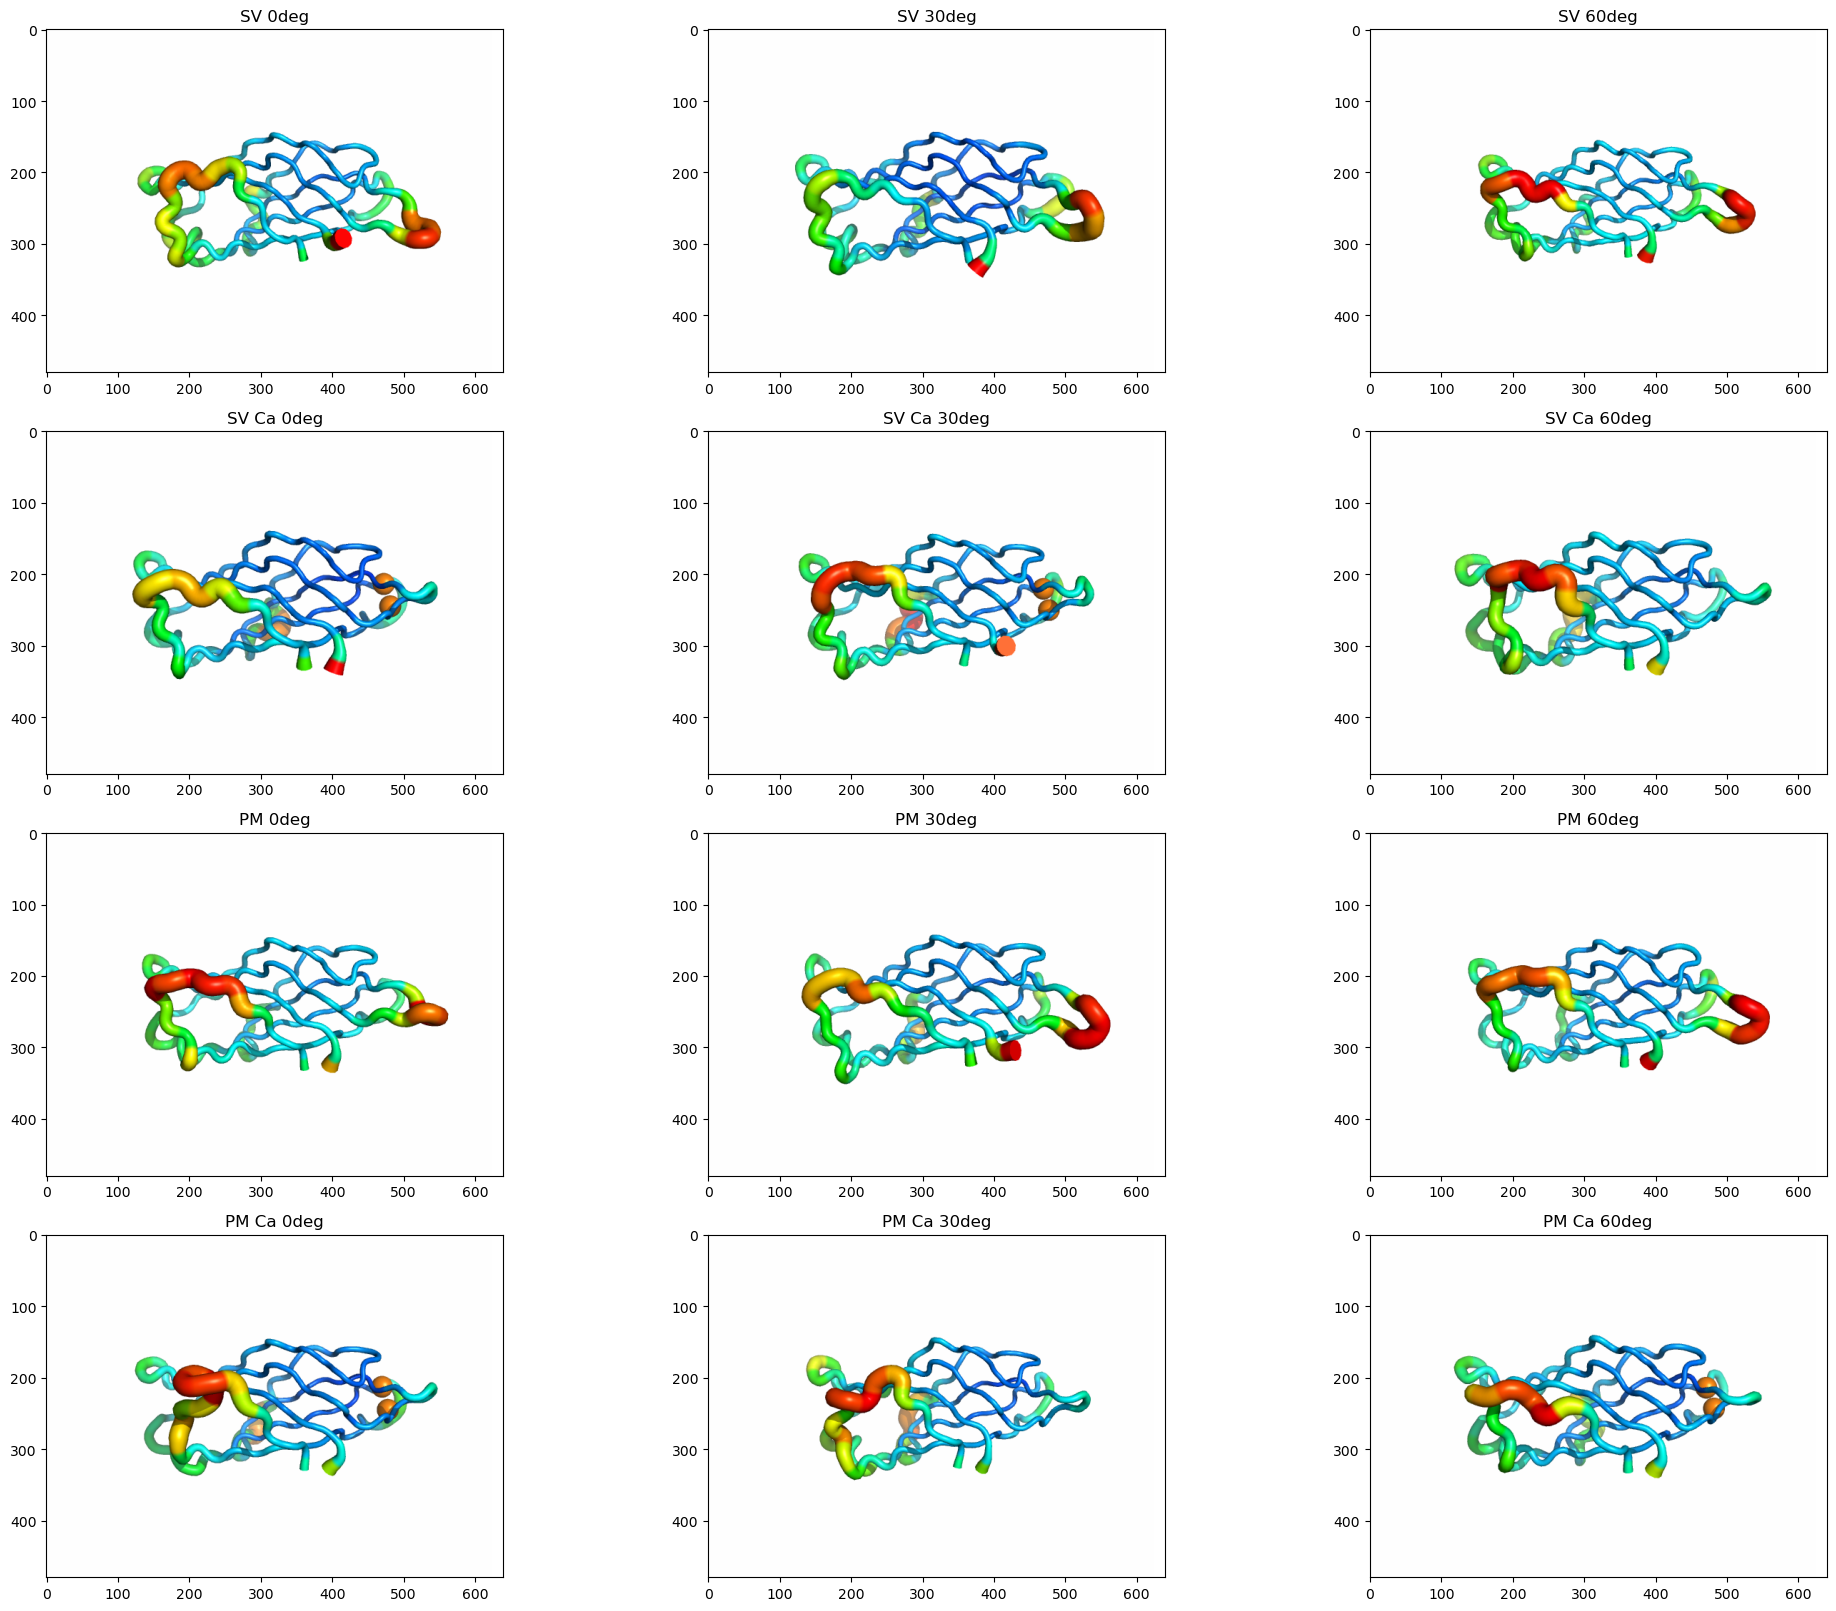

In [13]:
from io import BytesIO
import PIL
from IPython.display import display, Image
import matplotlib.pyplot as plt

titles = [' '.join(files[-2:]) for files in universes]
images = [os.path.abspath(os.path.join(os.path.split(files[0][0])[0], 'rmsf_tempfactors.png')) for files in universes]
   
plt.figure(figsize=(20,20))
columns = 3
for i, image in enumerate(images):
    ax = plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
    plt.imshow(PIL.Image.open(image))
    ax.title.set_text(titles[i])

plt.tight_layout()

plt.savefig("figures/c2a_RMSF_bfactor.pdf")

The absence of Ca ions in some RMSF visualisations comes from PBCs that moved the Ca to the other side of the Box. 

## RMSD analysis of SV Ca residues 186-195
The RMSF plot shows a more flexible behaviour of C2A SV Ca in this region. This might come from actual flexibilty (which would be a result) or from not enough sampling. The latter should be visible from convergence of an RMSD plot of this region aligned at the stable flanking regions.

In [14]:
def rmsd_array2df(arr, condition='', membrane=''):
    df = pd.DataFrame(arr, columns=['Frame', 'Time (ps)', 'Selection RMSD (Angs)', '189-190 RMSD (Angs)', '172-174 RMSD (Angs)'])
    df['Condition'] = condition
    df['Membrane'] = membrane
    return df

loop_rmsd = []
for files in universes:

    print("Reading files from:\n{}".format(*files[0]))
    u = Universe(*files[0])

    # the residue numbering in the PDB file is UniProt - 140
    # Looking at residues 189-190
    LOOP1 = 'protein and name CA and (resid 49-50)'
    # Residues 172 - 174
    LOOP2 = 'protein and name CA and (resid 32-34)'
    
    R = RMSD(u,  # universe to align
             u,  # reference universe or atomgroup
             # use residues 196-208 and 169-184 for superimposition
             #select='protein and name CA and (resid 56-68 or resid 29-44)',  # group to superimpose and calculate RMSD
             select = 'protein and name CA',
             groupselections=[LOOP1, LOOP2],
             ref_frame=0)  # frame index of the reference
    R.run()
    loop_rmsd.append(rmsd_array2df(R.rmsd, condition=files[-1], membrane=files[-2]))

loop_rmsd_df = pd.concat(loop_rmsd)

loop_rmsd_df['Time (ns)'] = loop_rmsd_df['Time (ps)']/1000

loop_rmsd_df.sort_values(by=['Time (ps)', 'Membrane', 'Condition'], inplace=True)

loop_rmsd_df.tail()

Reading files from:
../sv_membrane/c2a_only/0_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../sv_membrane/c2a_only/30_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../sv_membrane/c2a_only/60_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../sv_membrane/c2a_ca/0_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../sv_membrane/c2a_ca/30_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../sv_membrane/c2a_ca/60_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../pm_membrane/c2a_only/0_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../pm_membrane/c2a_only/30_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../pm_membrane/c2a_only/60_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../pm_membrane/c2a_ca/0_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../pm_membrane/c2a_ca/30_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../pm_membrane/c2a_ca/60_deg/parse_traj_1500ns_nowater.gro


Frame  Time (ps)  Selection RMSD (Angs)  189-190 RMSD (Angs)  \
1500  1500.0  1500000.0               1.583356             0.938075   
1500  1500.0  1500000.0               2.075384             2.673873   
1500  1500.0  1500000.0               1.275615             4.862215   
1500  1500.0  1500000.0               1.325453             1.978590   
1500  1500.0  1500000.0               1.195326             1.219222   

      172-174 RMSD (Angs) Condition Membrane  Time (ns)  
1500             5.939015      0deg       SV     1500.0  
1500             6.317320     60deg       SV     1500.0  
1500             1.975877      0deg    SV Ca     1500.0  
1500             1.063746     30deg    SV Ca     1500.0  
1500             0.857249     60deg    SV Ca     1500.0

In [15]:
loop_rmsd_df_grouped = loop_rmsd_df.groupby(['Membrane', 'Time (ns)'])['189-190 RMSD (Angs)'].agg(['mean', 'min', 'max'])
loop_rmsd_df_grouped.columns = ['Mean RMSD (Angs)', 'rmsd_min', 'rmsd_max']
loop_rmsd_df_grouped = loop_rmsd_df_grouped.reset_index()

fig = plotly_linewitharea(loop_rmsd_df_grouped,
                               x='Time (ns)',
                               y='Mean RMSD (Angs)',
                               ylower='rmsd_min',
                               yupper='rmsd_max',
                               title='Calpha RMSD of residues 189-190',
                               color='Membrane',
                               template='presentation')

save_figures(fig, "figures/c2a_RMSD_resid_189-190")

In [16]:
fig = px.line(loop_rmsd_df[loop_rmsd_df['Membrane'] =='SV Ca'],
               x='Time (ns)',
               y='189-190 RMSD (Angs)',
               title='Calpha RMSD of residues 189-190',
               color='Condition',
               template='presentation')

save_figures(fig, 'figures/c2b_RMSD_resid_189-190_sv_ca')


In [17]:
loop_rmsd_df_grouped = loop_rmsd_df.groupby(['Membrane', 'Time (ns)'])['172-174 RMSD (Angs)'].agg(['mean', 'min', 'max'])
loop_rmsd_df_grouped.columns = ['Mean RMSD (Angs)', 'rmsd_min', 'rmsd_max']
loop_rmsd_df_grouped = loop_rmsd_df_grouped.reset_index()

fig = plotly_linewitharea(loop_rmsd_df_grouped,
                               x='Time (ns)',
                               y='Mean RMSD (Angs)',
                               ylower='rmsd_min',
                               yupper='rmsd_max',
                               title='Calpha RMSD of residues 172-174',
                               color='Membrane',
                               template='presentation')

save_figures(fig, "figures/c2a_RMSD_resid_172-174")

Calcium has a destabilising effect on Loop 189-190 (orange) at least in the simulation involving the SV membrane whereas it stabilises Residues 172-174 (red). Potentially this indicates interaction of the lateral residues with lipids during the trajectory.
![c2a_loop_locations](figures/c2a_loop_locations.png)